## Question 2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import time

Now consider the multiclass problem in which we have different types of customers. 
- Assume that there are 5 types of customers with ch = {1, 1.5, 2, 2.5, 3}
- Each type can have maximum 100 people of each class waiting for shuttle
- At for each class follows same distribution
- Capacity of the shuttle is K = 30.

### Value Iteration

In [2]:
max_time = 500

K = 3 # platform capacity per class
ch = [-1, -1.5, -2, -2.5, -3]  # cost per customer left waiting per time period
cf = -100 # cost of dispatching a shuttle

cap = 30 # shuttle capacity
gamma = 0.95

theta = 10e-6

In [3]:
def load_shuttle(current_state, cap):
    # let the highest class customers get on the shuttle first
    result = current_state.copy()
    for i in range(4, -1, -1):
        result[i] = max(current_state[i]-cap, 0)
        cap = cap - abs(current_state[i]-result[i])
    return(result)

In [4]:
def get_reward(states, ch, cf, cap):
    # value of no shuttle
    Vt_no_shut = sum(np.multiply(states, ch))
    
    # let the highest class customers get on the shuttle first
    future_state = load_shuttle(states, cap)
    Vt_shut = cf + sum(np.multiply(future_state, ch))
    
    # return reward
    return(Vt_no_shut, Vt_shut)

In [5]:
def get_expected_future(state, arrivals, Vt_future, gamma, K, cap):
    # make all the iterations of new people arriving
    new_people = []
    for people in arrivals: 
        new_people.append(np.add(people,state))
    new_people = np.clip(new_people, 0, K-1)
    
    # expected future of no shuttle
    no_shut = 0
    for group in new_people:
        no_shut = no_shut + ((1/len(arrivals)) * gamma * Vt_future[tuple(group)])
        
    # expected future of shuttle
    shut = 0
    for group in new_people:
        new_group = load_shuttle(group, cap)
        shut = shut + ((1/len(arrivals)) * gamma * Vt_future[tuple(new_group)])
    return(no_shut, shut)

In [6]:
# initializes empty value dictionaries
# the key for each value is the number of people of each class
Vt = {}
for st0 in range(K): # every state
    for st1 in range(K):
        for st2 in range(K):
            for st3 in range(K):
                for st4 in range(K):
                    Vt[(st0,st1,st2,st3,st4)] = 0
Vt_future = Vt.copy()

In [7]:
# at any given time t, between 1 and 5 people of each class can arrive
# this iterates out all of them 
arrivals = []
for st0 in range(1, 6): # every state
    for st1 in range(1,6):
        for st2 in range(1,6):
            for st3 in range(1,6):
                for st4 in range(1,6):
                    arrivals.append([st0,st1,st2,st3,st4])

In [8]:
t1 = time.time()
while True: # policy iteration
    Vt_future = Vt.copy()
    delta = 0
    for st0 in range(K): # every state for ever class of customers
        for st1 in range(K):
            for st2 in range(K):
                for st3 in range(K):
                    for st4 in range(K):
                        rewards = get_reward([st0,st1,st2,st3,st4], ch, cf, cap)
                        future = get_expected_future([st0,st1,st2,st3,st4], arrivals, Vt_future, gamma, K, cap)
                        
                        no_shuttle = rewards[0] + future[0]
                        shuttle = rewards[1] + future[1]
                        Vt[tuple([st0,st1,st2,st3,st4])] = max(no_shuttle, shuttle)
                        delta = max(delta, abs(Vt[tuple([st0,st1,st2,st3,st4])] - \
                                               Vt_future[tuple([st0,st1,st2,st3,st4])]))
    if(delta < theta):
        break
    
t2 = time.time()
print("Time elapsed (sec): ", t2-t1)

Time elapsed (sec):  3433.222119808197


In [9]:
hours = (t2-t1)/3600
print(round(hours,2), "hours")

0.95 hours


### Plotting

In [10]:
# get values for the lowest class, when there are 0 people from each other class
result = []
for i in range(K):
    result.append(Vt[(i,0,0,0,0)])

Text(0,0.5,'Value')

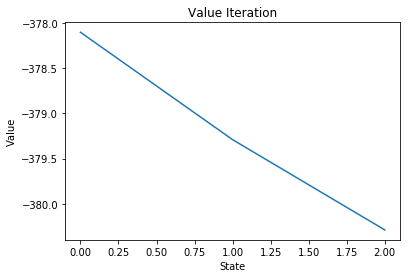

In [11]:
plt.plot(range(K), result)
plt.title("Value Iteration")
plt.xlabel("State")
plt.ylabel("Value")